In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = 'TRUE'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dc_gan import Discriminator, Generator, init_weights

In [3]:
learning_rate = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
# If you train on MNIST, remember to set channels_img to 1
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms, download=True)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
init_weights(gen)
init_weights(disc)
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

gen.train()
disc.train()

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [5]:
def save_and_display_images(images_tensor, epoch, batch_idx, num_images=8):
    grid = vutils.make_grid(images_tensor[:num_images], nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.title(f'Generated Images - Epoch {epoch}, Batch {batch_idx}')
    plt.show()  

Epoch [0/5] Batch 0/469                   Loss D: 0.6960, loss G: 0.7883


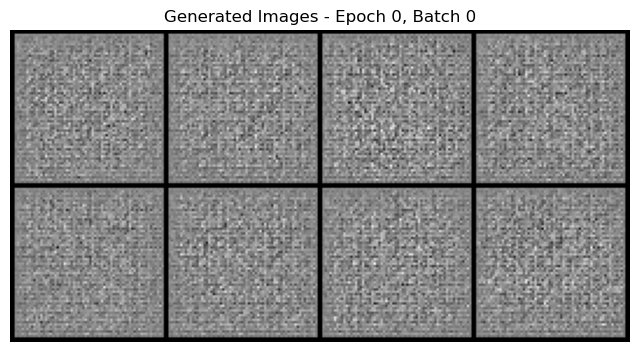

Epoch [0/5] Batch 100/469                   Loss D: 0.0151, loss G: 4.0692


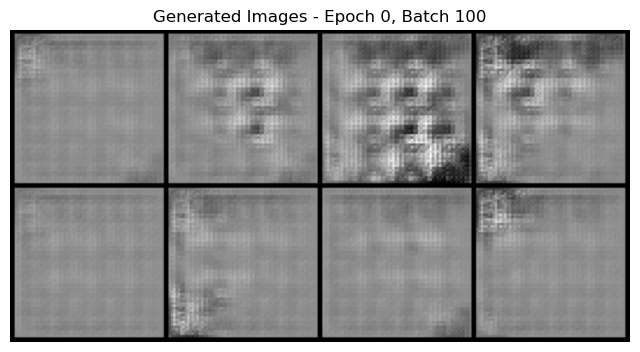

Epoch [0/5] Batch 200/469                   Loss D: 0.5541, loss G: 0.4345


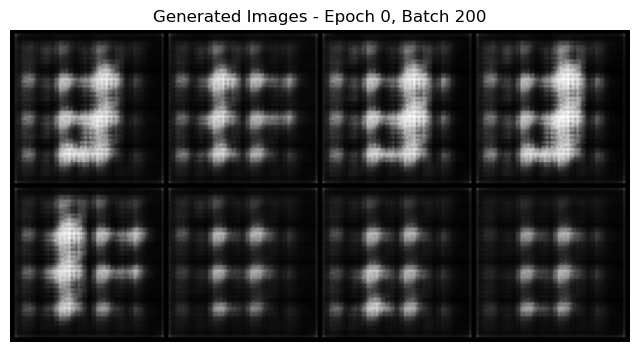

Epoch [0/5] Batch 300/469                   Loss D: 0.6200, loss G: 0.8603


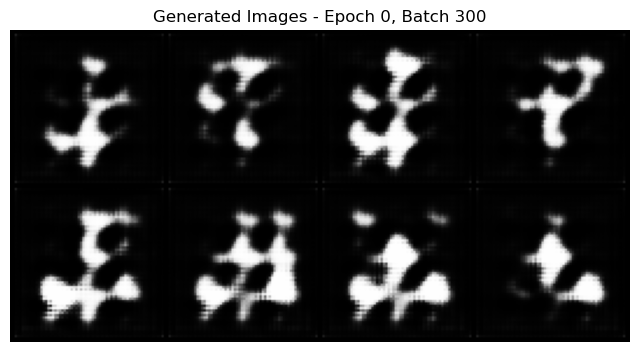

Epoch [0/5] Batch 400/469                   Loss D: 0.5245, loss G: 1.1739


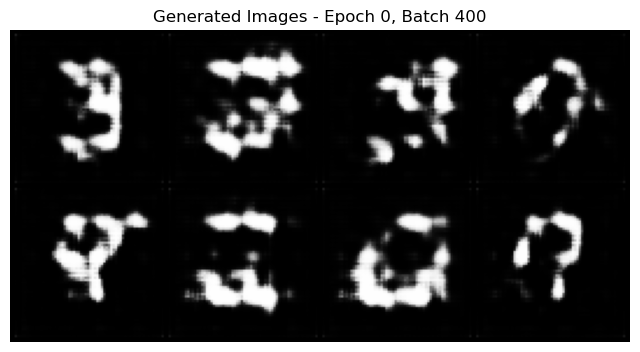

Epoch [1/5] Batch 0/469                   Loss D: 0.4991, loss G: 1.2053


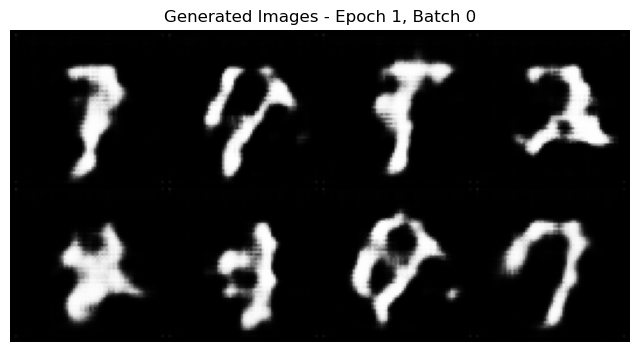

Epoch [1/5] Batch 100/469                   Loss D: 0.6006, loss G: 0.8585


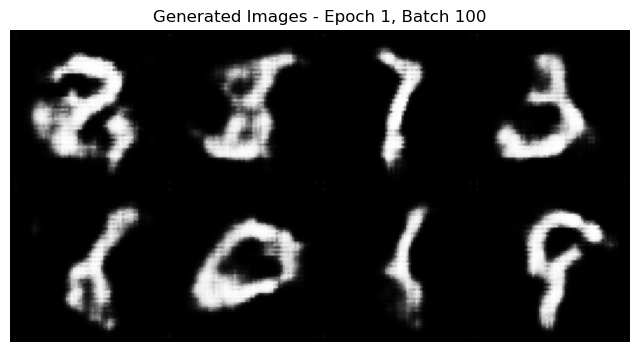

Epoch [1/5] Batch 200/469                   Loss D: 0.6660, loss G: 0.7242


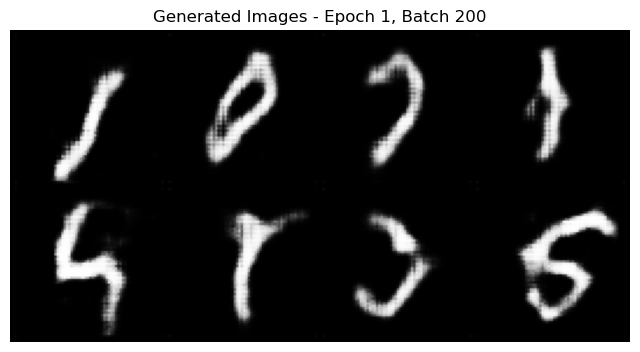

Epoch [1/5] Batch 300/469                   Loss D: 0.6139, loss G: 0.9865


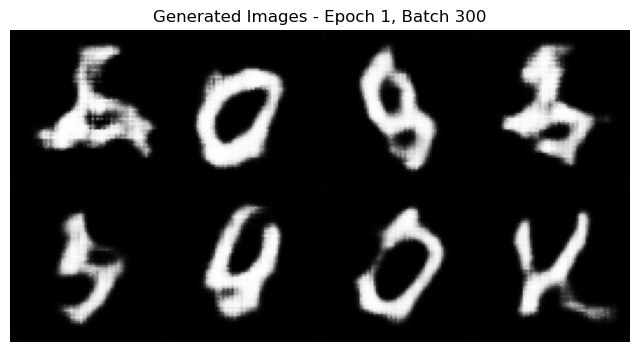

Epoch [1/5] Batch 400/469                   Loss D: 0.6072, loss G: 0.8477


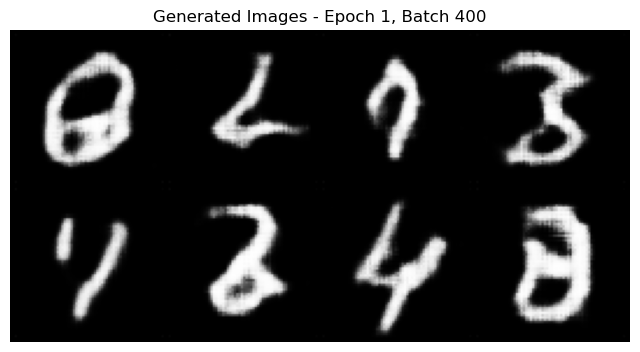

Epoch [2/5] Batch 0/469                   Loss D: 0.6068, loss G: 0.9090


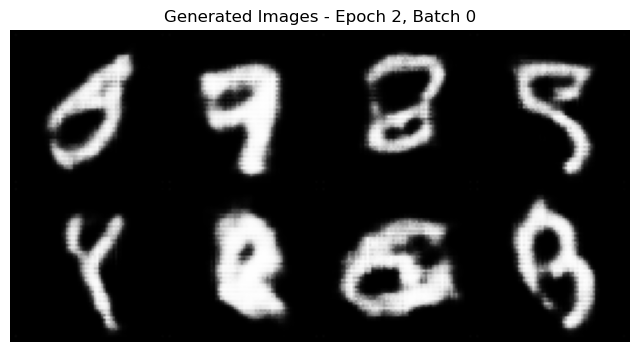

Epoch [2/5] Batch 100/469                   Loss D: 0.6837, loss G: 0.6821


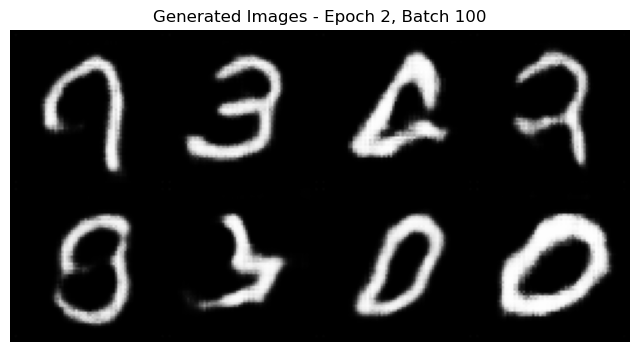

Epoch [2/5] Batch 200/469                   Loss D: 0.5810, loss G: 1.0190


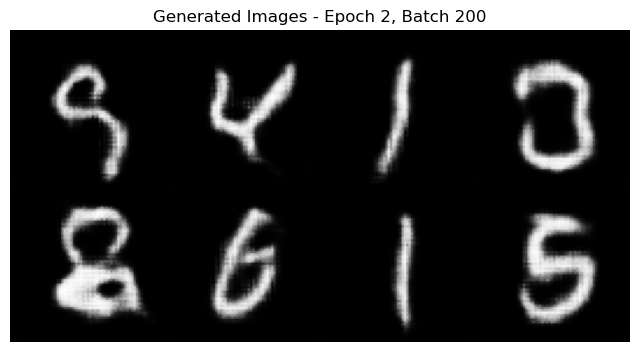

Epoch [2/5] Batch 300/469                   Loss D: 0.5767, loss G: 0.9938


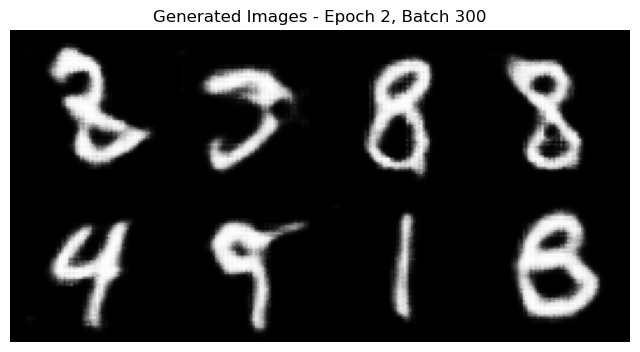

Epoch [2/5] Batch 400/469                   Loss D: 0.7295, loss G: 2.0644


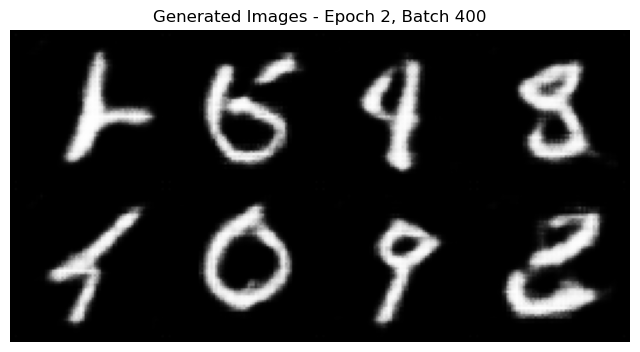

Epoch [3/5] Batch 0/469                   Loss D: 0.5056, loss G: 0.8415


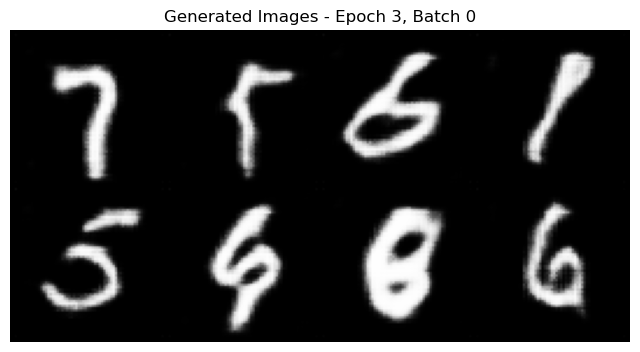

Epoch [3/5] Batch 100/469                   Loss D: 0.3940, loss G: 1.7915


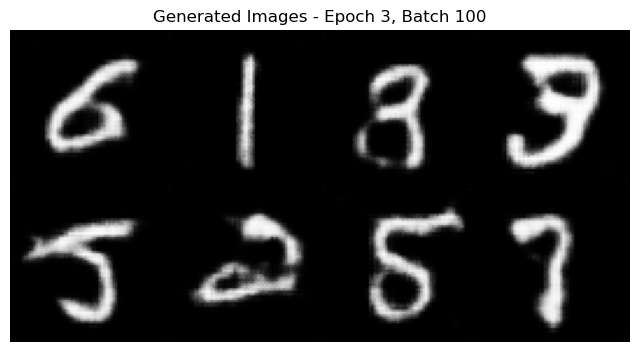

Epoch [3/5] Batch 200/469                   Loss D: 0.3663, loss G: 1.7629


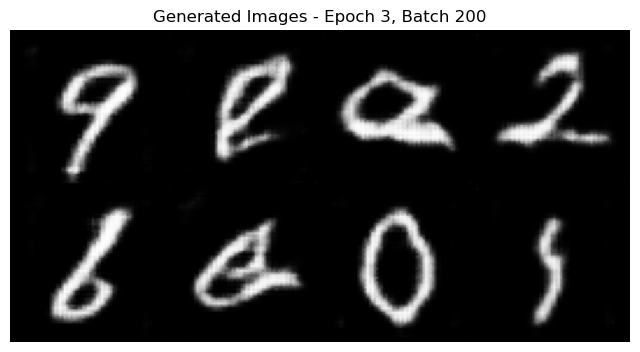

Epoch [3/5] Batch 300/469                   Loss D: 0.7856, loss G: 0.8880


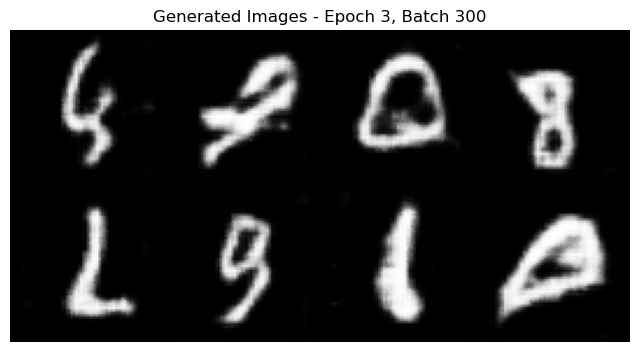

Epoch [3/5] Batch 400/469                   Loss D: 0.2699, loss G: 2.1018


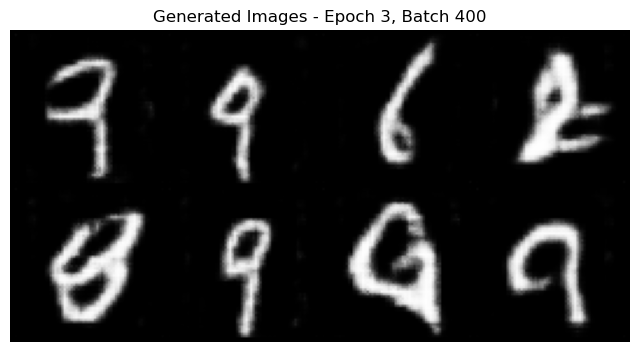

Epoch [4/5] Batch 0/469                   Loss D: 0.3457, loss G: 4.9921


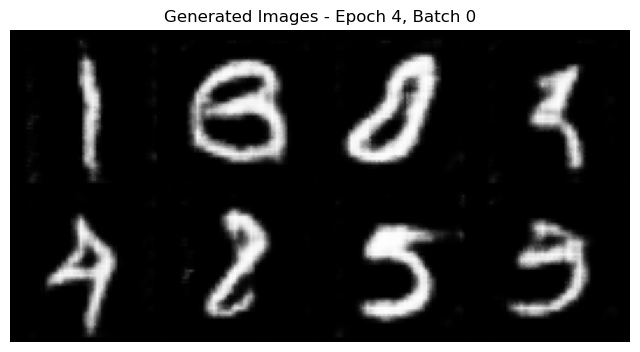

Epoch [4/5] Batch 100/469                   Loss D: 0.2192, loss G: 1.6276


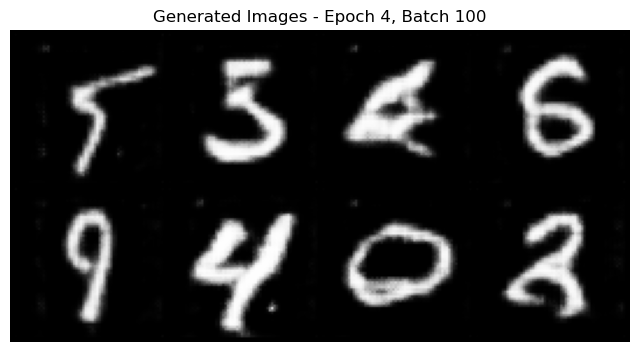

Epoch [4/5] Batch 200/469                   Loss D: 0.3075, loss G: 1.8485


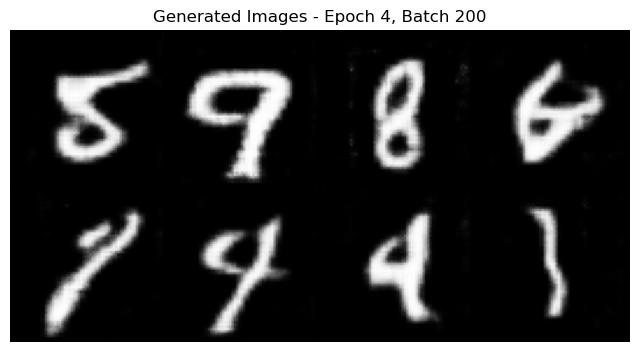

Epoch [4/5] Batch 300/469                   Loss D: 0.1639, loss G: 2.7452


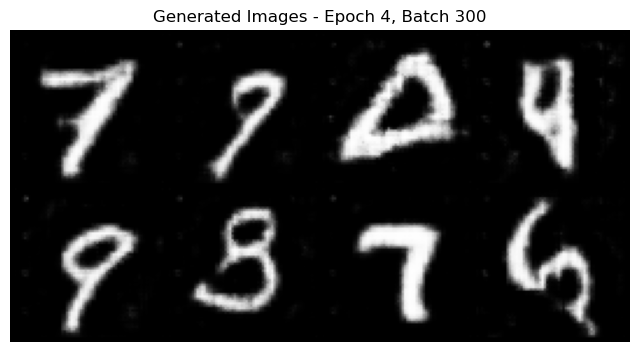

Epoch [4/5] Batch 400/469                   Loss D: 0.2035, loss G: 2.1363


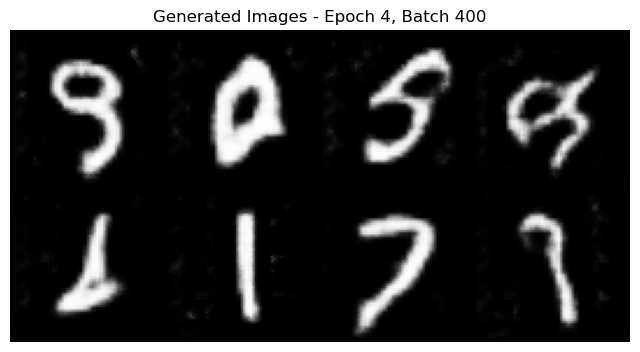

In [6]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

generator_loss = []
discriminator_loss = []
inception_scores_mean = []
inception_scores_std = []

for epoch in range(NUM_EPOCHS):
    disc_loss = 0
    gen_loss = 0
    for batch_idx, (real, _) in enumerate(dataloader):
        #print(real.shape)
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))       
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc_loss += loss_disc.item()
        
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen_loss += loss_gen.item()
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

        if batch_idx % 100 == 0:
            save_and_display_images(fake, epoch, batch_idx)

    generator_loss.append(gen_loss / len(dataloader))
    discriminator_loss.append(disc_loss / len(dataloader))

    """is_mean, is_std = calculate_inception_score(gen, num_samples=50000, batch_size=BATCH_SIZE, device=device)
    inception_scores_mean.append(is_mean)
    inception_scores_std.append(is_std)"""